In [2]:
import xarray as xr
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(suppress=True)

def mean_and_std(var):
    height=var.height.values
    lon=var.lon.values
    
    for dim_name in var.dims:
        if dim_name == 'lat':
            nlat=len(var.lat.values)
            nlon=len(var.lon.values)
            reshape_size= ( var.height.size, nlat*nlon)
            var = var.values.reshape(reshape_size)
            new_lon=np.linspace(0, nlat*nlon-1, nlat*nlon)
            var = xr.DataArray(var, coords=[height, new_lon], dims = ['height','lon'])
            
    var_mean = var.mean('lon')
    var_std = var.std(dim='lon')
    
    std_p = var_mean + var_std
    std_n = var_mean - var_std
    
    return std_n.squeeze(), var_mean.squeeze(), std_p.squeeze()

fs = 20
plt.rcParams.update({'font.size': fs})
height_b = 84. #85.
z_min = 25. #min z for 3d var
lat_sel = [0., [7.,-7.], [15., -15.]]

z_ifc = xr.open_dataset('../../z_ifc.nc')['z_ifc']
z_ifc = z_ifc.where(z_ifc.height_2 >= z_min, drop=True)
z_full = 0.5*(z_ifc[:-1] + z_ifc[1:].values)
z_full = z_full*0.001

at 0.0 | hb: 337.08 | hm: 328.88 | hb-hm: 8.20
delta_S: 14.17
[299.53984789 299.58022687]
at [8.0, -8.0] | hb: 334.65 | hm: 324.28 | hb-hm: 10.37
delta_S: 14.22
[299.29268129 299.33137913]
at [15.0, -15.0] | hb: 328.10 | hm: 318.46 | hb-hm: 9.64
delta_S: 14.20
[297.43396251 297.47006002]
at 0.0 | hb: 335.70 | hm: 327.37 | hb-hm: 8.33
delta_S: 13.86
[299.72448496 299.76356309]
at [8.0, -8.0] | hb: 332.16 | hm: 322.16 | hb-hm: 10.00
delta_S: 14.07
[299.46893418 299.50597963]
at [15.0, -15.0] | hb: 327.96 | hm: 319.42 | hb-hm: 8.54
delta_S: 13.92
[297.91928463 297.94743656]
at 0.0 | hb: 336.34 | hm: 327.88 | hb-hm: 8.45
delta_S: 13.85
[299.66465525 299.7061426 ]
at [8.0, -8.0] | hb: 333.52 | hm: 322.05 | hb-hm: 11.48
delta_S: 14.25
[299.02901972 299.07776231]
at [15.0, -15.0] | hb: 327.27 | hm: 317.51 | hb-hm: 9.76
delta_S: 14.17
[297.221622  297.2617357]
at 0.0 | hb: 336.37 | hm: 327.75 | hb-hm: 8.62
delta_S: 13.84
[299.72118481 299.75991365]
at [8.0, -8.0] | hb: 333.06 | hm: 322.48 | hb

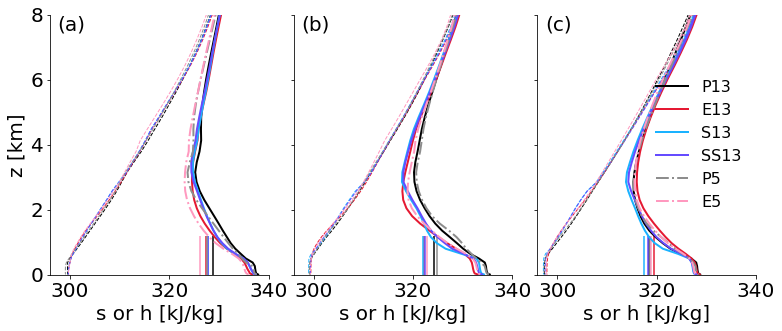

In [3]:
import glob

def f_slope(X,Y,ax=0):
    s=np.diff(Y, axis=ax)/np.diff(X,axis=ax)
    
    return np.mean(s, axis=ax)

#colors = ['#111111','#64CBCF', '#006D6D','#9F3B40', 'gray','#FF9AA1']
#colors = ['#000000','#295F8A', '#AFCBE3','#E21F26', '#777777', '#AD71B5']
colors = ['#000000','#E51932','#1AB2FF','#654CFF','#8D8D8D','#FF99BF']
labels=['P13','E13','S13','SS13','P5','E5']

flists=['param','explicit','shallow','stochastic_shallow', 'P5','E5']
        #'high_res_param','high_resolution']
#fig, axs = plt.subplots(1,3, figsize=(16,5), sharey=True)
fig, axs = plt.subplots(1,3, figsize=(11,5), sharey=True)
plt.subplots_adjust(wspace=0.27)

hm_1=84.
hm_2=67.
lat_sel = [0., [8.,-8.], [15., -15.]]
lw = 2
ls = list(['solid'])*4 + list(['dashdot'])*2

xmins = [320, 315, 310]
xmaxs = [340, 335, 330]
for i, od in enumerate(flists):
    ds = xr.open_dataset('data/%s/ke_var_timeavg.nc' % od)
    ds['lat']=np.round(ds.lat, 2)

    for j in range(len(lat_sel)):
        var = ds.h.sel(lat=lat_sel[j])
        dse = ds.s.sel(lat=lat_sel[j])

        hb = var.where(ds.height >= height_b, drop=True).mean('height')
        #print('hb: %.2f' % hb.mean('lon').values)

        hm = var.where( ( ds.height <= height_b ) & (ds.height >= hm_2), drop=True)
        hm = hm.mean('height')*0.001
        #var_m = var.where(var.height >= 51., drop = True)
        #hm=var_m.where(var_m <= hb, drop=True).mean('height')*0.001
        axs[j].vlines(hm.mean(), 0, 1.2, color=colors[i])
        hb = hb.mean().values*0.001
        hm = hm.mean()
        print("at %s | hb: %.2f | hm: %.2f | hb-hm: %.2f" % (lat_sel[j], hb, hm, hb-hm))

        var_n, var_mean, var_p = mean_and_std(var*0.001)
        dse_n, dse_mean, dse_p = mean_and_std(dse*0.001)

        slope = f_slope(z_full.sel(height_2=slice(hm_2,hm_1)),dse_mean.sel(height=slice(hm_2, hm_1)))
        print("delta_S: %.2f" % (slope + 9.8))
        axs[j].plot(var_mean, z_full, lw = lw, label=labels[i], color= colors[i], ls=ls[i])
        #axs[j].plot(var_n, z_full, ls='dotted', color= colors[i])
        #axs[j].plot(var_p, z_full, ls='dotted', color= colors[i])

        axs[j].plot(dse_mean, z_full, lw = 1, color=colors[i], ls = 'dashed')
        print(dse_mean[-2:].values)
        #axs[j].plot(dse_n, z_full, color=colors[i], ls='dotted')
        #axs[j].plot(dse_p, z_full,  color=colors[i], ls='dotted')
        axs[j].set_xlim(xmins[j], xmaxs[j])


titles = ['(a)' ,'(b)','(c)']
for i, ax in enumerate(axs.flat):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,8)
    #ax.set_xlim(310, 340)
    ax.set_xlim(296, 340)
    #ax.text(311,7.5,titles[i])
    ax.text(297.5,7.5,titles[i])
    ax.set_xlabel('s or h [kJ/kg]')
    #ax.hlines(0.5, 296, 340, color='black')

axs[2].legend(loc='center right',fontsize=fs*0.8, frameon=False)
axs[0].set_ylabel('z [km]', fontsize=fs)
fig.tight_layout()